In [1]:
import csv
import skimage
from skimage import data
from numpy import array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import load_model
import os

from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
import timeit
from skimage.color import rgb2gray
from skimage.util import pad
import pprint

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [2]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'resNet_LP_cz_paper_epoch200.h5'
model_path = os.path.join(save_dir, model_name)
#print(model_path)
k_model = load_model(model_path)

In [19]:
n_images=0
n_plates=0
testImages=[]
testLabels=[]
length=2
width =2


In [20]:
pad_shape = ((int(length), int(length)), (int(width), int(width)))
csv.register_dialect('myDialect',
delimiter = ',',
skipinitialspace=True)
with open('trainVal.csv','r') as csvFile:
    reader = csv.reader(csvFile,dialect='myDialect')
    for row in reader:
#         if row[3]=='1':
#             img=skimage.data.imread(row[1])
#             img = skimage.transform.resize(img,(40,200,3))
            
            
#             #### face different length of license
#             x_trainLabel=str(row[2])
#             if len(x_trainLabel)==7:
#                 trainImages.append(img)
#                 trainLabels.append(x_trainLabel[0:3]+'#'+x_trainLabel[3:])
#             if len(x_trainLabel)==6:
#                 trainImages.append(img)
#                 trainLabels.append(x_trainLabel[0:3]+'..'+x_trainLabel[3:])
#             if len(x_trainLabel)==5:
#                 trainImages.append(img)
#                 trainLabels.append(x_trainLabel[0]+'###'+x_trainLabel[1:])
                
        if row[3]=='0':
            img=skimage.data.imread(row[1])
            img = skimage.transform.resize(img,(10,50,3))
            img = rgb2gray(img)
            
            img= pad(img, pad_width=pad_shape, mode='mean')
            
            
            img = skimage.color.gray2rgb(img)
            img = skimage.transform.resize(img,(40,200,3))
            
            x_testLabel=str(row[2])
            if len(x_testLabel)==7:
                testImages.append(img)
                n_images=n_images+1 
                testLabels.append(x_testLabel[0:3]+'#'+x_testLabel[3:])
            if len(x_testLabel)==6:
                testImages.append(img)
                n_images=n_images+1 
                testLabels.append(x_testLabel[0:3]+'..'+x_testLabel[3:])
                #skimage.io.imsave('images5/'+str(n_images)+'.jpg',img)
            if len(x_testLabel)==5:
                testImages.append(img)
                n_images=n_images+1 
                testLabels.append(x_testLabel[0]+'###'+x_testLabel[1:])
                #skimage.io.imsave('images5/'+str(n_images)+'.jpg',img)
         
        if n_images==100:
            break
        #print(n_images)
        #print(row,row[3])

In [21]:
len(testImages),n_images

(100, 100)

In [22]:
# define universe of possible input values
alphabet = '0123456789abcdefghijklmnopqrstuvwxyz#. '.upper()
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

In [23]:
list_testLabels=list()
for testlabel in testLabels:
    test_encoded = [char_to_int[char] for char in testlabel]
    for value in test_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        list_testLabels.append(letter)

In [24]:
testY=np.array(list_testLabels)
testX=np.array(testImages)

In [25]:
testY=testY.reshape(len(testLabels),8,39)
testX=testX.reshape(len(testImages),testImages[0].shape[0],
                           testImages[0].shape[1],
                           testImages[0].shape[2]).astype("float32")/255

In [26]:
#del testImages
#del list_testLabels

In [46]:
def prediction_test_acc(model,dataset,datasetLabel):#it can test the confidence in dataset
    license=0
    total_license=0
    character =0 
    total_character=0
    correct_prediction_LP=[]
    incorrect_prediction_LP=[]
    correct_confidence=[]
    incorrect_confidence=[]
    correct_groundtruth=[]
    incorrect_groundtruth=[]
    correct_img=[]
    incorrect_img=[]
    correct_topN_confidence=[]
    incorrect_topN_confidence=[]
    correct_topN_prediction=[]
    incorrect_topN_prediction=[]
    topN=2
    
    # define universe of possible input values
    alphabet = '0123456789abcdefghijklmnopqrstuvwxyz#. '.upper()
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    for n in range(0,len(dataset)):
        p=model.predict_on_batch(dataset[n:n+1])
        truth = datasetLabel[n]
        img=dataset[n]
        for x in range(0,8):
            total_character+=1
            
            if int_to_char[argmax(truth[x])]==int_to_char[argmax(p[x])]:
                character+=1
        total_license+=1
        if (int_to_char[argmax(truth[0])]==int_to_char[argmax(p[0])] and
            int_to_char[argmax(truth[1])]==int_to_char[argmax(p[1])] and
            int_to_char[argmax(truth[2])]==int_to_char[argmax(p[2])] and 
            int_to_char[argmax(truth[3])]==int_to_char[argmax(p[3])] and
            int_to_char[argmax(truth[4])]==int_to_char[argmax(p[4])] and
            int_to_char[argmax(truth[5])]==int_to_char[argmax(p[5])] and
            int_to_char[argmax(truth[6])]==int_to_char[argmax(p[6])] and
            int_to_char[argmax(truth[7])]==int_to_char[argmax(p[7])]):
            license+=1
            correct_img.append(img)
            temp_correct_confidence=[]
            temp_correct_groundtruth=[]
            temp_correct_prediction_LP=[]
            temp_correct_topN_confidence=[]            
            temp_correct_topN_prediction=[]
            for x in range(0,8):
                temp_correct_confidence.append(p[x].max())
                temp_correct_groundtruth.append(int_to_char[argmax(truth[x])])
                temp_correct_prediction_LP.append(int_to_char[argmax(p[x])])
                           
                                
                #remove the max confidence value
                p[x][0][argmax(p[x])]=0
                temp_correct_topN_prediction.append(int_to_char[argmax(p[x])])
                temp_correct_topN_confidence.append(p[x][0][int(p[x][0].argsort()[-1])])
                #print(hash_list)
                #print(temp_correct_topN_confidence)
            correct_confidence.append(temp_correct_confidence)
            correct_groundtruth.append(temp_correct_groundtruth)
            correct_prediction_LP.append(temp_correct_prediction_LP)
            correct_topN_confidence.append(temp_correct_topN_confidence)
            correct_topN_prediction.append(temp_correct_topN_prediction)
                
        else:
            incorrect_img.append(img)
            temp_incorrect_confidence=[]
            temp_incorrect_groundtruth=[]
            temp_incorrect_prediction_LP=[]
            temp_incorrect_topN_confidence=[]            
            temp_incorrect_topN_prediction=[]
            for x in range(0,8):
                temp_incorrect_confidence.append(p[x].max())
                temp_incorrect_groundtruth.append(int_to_char[argmax(truth[x])])
                temp_incorrect_prediction_LP.append(int_to_char[argmax(p[x])])
                
                                #remove the max confidence value
                p[x][0][argmax(p[x])]=0
                temp_incorrect_topN_prediction.append(int_to_char[argmax(p[x])])
                temp_incorrect_topN_confidence.append(p[x][0][int(p[x][0].argsort()[-1])])
                print(p[x][0])
                
                
            incorrect_confidence.append(temp_incorrect_confidence)
            incorrect_groundtruth.append(temp_incorrect_groundtruth)
            incorrect_prediction_LP.append(temp_incorrect_prediction_LP)
            incorrect_topN_confidence.append(temp_incorrect_topN_confidence)
            incorrect_topN_prediction.append(temp_incorrect_topN_prediction)
            print('\n')
            print(incorrect_topN_confidence)
                
                
    license_acc = license/total_license
    character_acc = character/total_character
    return license_acc,character_acc,incorrect_groundtruth,correct_groundtruth,correct_confidence,incorrect_confidence,correct_img,incorrect_img,incorrect_prediction_LP,correct_prediction_LP,correct_topN_confidence,incorrect_topN_confidence,correct_topN_prediction,incorrect_topN_prediction

In [47]:
license_acc,character_acc,incorrect_groundtruth,correct_groundtruth,correct_confidence,incorrect_confidence,correct_img,incorrect_img,incorrect_prediction_LP,correct_prediction_LP,correct_topN_confidence,incorrect_topN_confidence,correct_topN_prediction,incorrect_topN_prediction= prediction_test_acc(k_model,testX,testY)

[1.5629906e-08 9.6689007e-04 5.9285523e-09 8.3813637e-07 5.8602804e-04
 0.0000000e+00 5.1167952e-03 3.4647263e-07 1.1843292e-02 1.7952227e-06
 1.2278648e-06 5.4755445e-12 7.6114839e-09 3.9909374e-13 3.1204117e-09
 1.3425781e-03 8.4935552e-09 9.6095243e-10 4.3119499e-09 1.2855029e-03
 2.9319875e-05 1.7694412e-06 4.7977361e-10 1.3993160e-06 1.4419155e-03
 3.2225671e-05 8.2950201e-04 4.5924229e-04 2.6728319e-15 1.5366255e-13
 1.5845151e-05 1.5877013e-08 1.7399572e-05 2.1516301e-03 7.8961032e-04
 1.2326147e-20 4.7863068e-04 9.5715775e-04 8.8797248e-04]
[2.0516824e-19 2.2965956e-16 1.5664478e-15 2.6610367e-19 5.3991269e-15
 5.4046784e-12 1.9570567e-12 7.6183553e-13 6.2546305e-12 5.7765611e-12
 1.6926106e-22 0.0000000e+00 5.8644734e-16 2.9448563e-13 8.1907643e-17
 4.2599539e-12 4.9417907e-17 3.5083160e-12 8.7815853e-15 1.7594051e-15
 9.5843495e-23 8.3196511e-18 4.9046214e-18 5.0060900e-18 5.3451371e-12
 2.0443945e-18 1.2099137e-13 1.2278626e-18 8.2442239e-14 2.5676072e-22
 1.2821899e-15 1.86

[1.2460905e-10 5.4349140e-08 3.9636256e-14 6.3283210e-08 2.5240064e-04
 0.0000000e+00 1.9985673e-03 4.3061331e-08 3.5236690e-06 3.1367537e-07
 2.6016675e-09 4.6904933e-18 1.3843008e-07 1.4352768e-16 1.9841562e-11
 6.1373230e-06 1.1791487e-11 5.3896825e-14 7.2999714e-12 7.9090287e-06
 1.3964830e-08 1.6569088e-10 3.9362499e-13 3.3310493e-10 9.3470253e-06
 3.6614821e-12 5.2289051e-06 8.0436884e-08 7.2939436e-16 2.4910562e-17
 7.5733141e-08 1.6021915e-11 2.0088864e-10 1.5130568e-05 4.7322183e-06
 3.2861986e-22 2.5825775e-06 4.2440693e-06 6.4716310e-06]
[5.42576990e-27 2.17531960e-23 1.81617722e-21 2.53417541e-27
 2.41465804e-22 6.82764442e-20 2.73266705e-18 6.83527774e-21
 5.37862365e-18 1.15285055e-17 4.64533957e-25 0.00000000e+00
 1.05171768e-26 2.10319799e-20 1.59271786e-24 6.29506449e-18
 2.26262297e-22 1.43548724e-21 9.69643970e-23 2.74208642e-25
 2.58297810e-32 4.82947241e-23 2.32655477e-27 1.31763634e-25
 1.74505893e-17 2.78519775e-22 2.82635518e-19 6.18941006e-26
 1.33582692e-23 1.

[2.2658138e-15 1.2846167e-06 4.4029340e-15 6.0242455e-10 3.4188093e-14
 0.0000000e+00 4.8279132e-09 1.5801262e-10 2.6007078e-04 2.2354871e-10
 4.5054601e-13 6.7551195e-12 1.8506842e-10 6.6660593e-13 6.7565264e-15
 5.6272031e-09 1.6011799e-12 7.2653771e-18 1.5984129e-15 7.7357294e-09
 3.9678462e-11 6.7519025e-11 7.3363940e-11 2.4735147e-10 8.4802361e-09
 4.2697585e-11 3.2159857e-09 7.0404160e-12 4.8212581e-21 3.9335168e-18
 1.0668853e-10 3.6976298e-14 2.5649938e-10 1.3996060e-08 2.8536431e-09
 9.9869373e-17 7.2882562e-09 6.3930190e-09 3.9321391e-09]
[1.16575378e-19 1.00259783e-14 2.21370949e-16 2.64371112e-14
 1.27398374e-16 6.42943137e-14 5.66765542e-15 1.82795097e-14
 1.12410038e-12 4.48454967e-13 2.20039237e-14 0.00000000e+00
 9.79111436e-22 2.40490787e-12 9.87311341e-20 5.05698510e-13
 5.81844279e-14 1.16105949e-17 3.19341480e-15 2.34458638e-13
 2.11703177e-23 8.70219017e-14 5.07803401e-14 2.70645871e-20
 1.15713157e-12 2.53069953e-18 2.21636471e-14 1.07158906e-20
 2.08942282e-17 4.

[8.89966826e-19 7.10417673e-13 1.58762927e-23 4.28736658e-16
 1.16572320e-18 2.54218033e-14 1.17307710e-14 9.28043112e-17
 0.00000000e+00 2.07193153e-15 4.05409981e-19 1.87843980e-19
 1.71233256e-16 8.69470221e-19 6.69833886e-22 1.60703665e-15
 3.19656322e-20 1.64346410e-24 3.17606710e-22 3.12265388e-15
 8.35437103e-20 1.82729807e-19 2.69666841e-20 2.77867868e-17
 1.82056645e-15 1.83812043e-19 1.40645999e-15 8.79145133e-20
 6.43582922e-31 6.44661125e-25 1.35707425e-17 9.58085014e-21
 1.52092334e-18 4.73041177e-15 1.67181889e-15 1.13234066e-22
 1.82423707e-15 2.21317851e-15 1.19828226e-15]
[2.53410317e-23 1.81123900e-19 2.14546530e-20 1.11758935e-18
 1.07006944e-20 2.27300878e-18 6.09982319e-19 1.10385772e-17
 1.09953008e-15 1.58828313e-16 7.12986923e-18 0.00000000e+00
 2.67730794e-26 2.78573784e-16 3.01977374e-24 4.74991989e-16
 2.13802564e-17 5.56487250e-27 4.20592675e-19 3.38319112e-21
 2.22100408e-28 1.36446479e-19 1.03783307e-17 5.71567788e-24
 7.79350621e-16 9.03550386e-20 8.97293

[1.6834900e-07 0.0000000e+00 7.6799497e-11 1.0205086e-06 4.6470436e-06
 2.0491408e-01 2.5029853e-05 4.0069938e-07 6.9627836e-03 1.2961717e-04
 1.6106082e-05 5.7894129e-05 1.7585997e-05 1.9194758e-08 5.0827516e-08
 7.5990818e-03 3.3128716e-04 1.2500455e-10 1.8414688e-08 5.7452861e-03
 9.4399722e-05 5.8905832e-02 3.3118535e-08 1.7938382e-06 9.7462535e-03
 3.2430986e-04 5.7355631e-03 1.0594750e-05 4.8937937e-18 1.9286947e-08
 8.5306463e-05 5.5712487e-08 2.4001449e-07 1.3130237e-02 3.7919013e-03
 2.7530522e-13 5.1022493e-03 5.3103594e-03 7.5566461e-03]
[8.24493386e-22 1.21131023e-07 4.18802948e-08 9.98077176e-10
 6.31500961e-06 3.36498888e-05 7.09563096e-07 1.06994404e-08
 1.90366336e-04 1.61276112e-04 1.10602612e-11 0.00000000e+00
 1.19182908e-09 1.77097420e-04 2.71169465e-05 4.67596074e-05
 1.54883537e-06 2.52239570e-12 7.44524016e-07 4.89084164e-12
 4.24262838e-12 2.79772450e-09 4.35071147e-15 9.85110549e-10
 7.59516261e-05 2.83970557e-14 2.29887362e-07 2.12457917e-06
 2.63288939e-06 4.

[2.8098817e-09 1.3255404e-06 8.3084310e-11 2.1617803e-08 1.0634164e-07
 1.1358479e-04 4.6306873e-06 6.7261940e-10 3.2536166e-03 0.0000000e+00
 1.1659695e-10 9.3090696e-14 8.6615476e-10 4.7931255e-13 4.9524496e-13
 4.6369954e-07 3.8836986e-11 4.2659431e-12 3.8079799e-14 4.1934609e-07
 3.6782783e-09 2.6293803e-08 2.6572221e-14 9.4286188e-06 4.8144341e-07
 6.6711374e-07 4.6452101e-07 2.8501083e-07 1.8342494e-11 2.7178211e-13
 6.4770674e-08 1.4080027e-07 3.6069134e-09 6.9399556e-07 2.2194297e-07
 1.8650142e-16 6.3356038e-07 2.9535764e-07 6.5341243e-07]
[9.74800121e-21 3.82139632e-12 5.82132287e-16 1.47943620e-18
 1.05472932e-14 1.05107190e-11 1.81161780e-13 2.13572209e-14
 2.30530022e-11 2.44008945e-11 1.11203791e-21 0.00000000e+00
 1.06500563e-16 2.36470674e-13 4.39224422e-13 5.21168568e-12
 5.57971996e-16 9.59362659e-11 7.99911556e-14 8.78694785e-15
 5.62568378e-19 4.19999897e-17 3.06454370e-17 3.33552740e-17
 1.76427449e-11 7.40484557e-18 3.38657325e-14 7.99962988e-15
 8.37753024e-15 1.

[2.1016485e-14 8.0722625e-12 2.4381250e-12 5.7658234e-10 0.0000000e+00
 7.2363805e-17 6.2662725e-16 6.2018938e-17 7.3764188e-13 1.9978285e-18
 8.8376697e-16 1.2819118e-14 6.1159994e-17 1.2391935e-18 2.6676368e-16
 3.8529801e-14 7.0639122e-13 1.0624158e-18 3.3036929e-24 1.4919530e-14
 4.1654705e-17 3.1712826e-16 1.3201327e-16 2.6673870e-20 7.4670638e-15
 1.3537889e-20 1.6378898e-14 2.1753949e-15 2.4732243e-20 7.4885586e-26
 6.9957610e-16 1.2671124e-14 5.2194911e-17 1.7164675e-14 1.3747451e-14
 3.7185276e-15 8.9854466e-15 1.5334517e-14 9.5795640e-15]
[1.02856021e-17 1.24646636e-12 3.02797648e-10 1.15584156e-17
 2.02550439e-08 9.99474459e-09 5.21969100e-11 7.10926110e-11
 5.06796716e-10 3.02097167e-11 0.00000000e+00 1.43681450e-06
 3.99566942e-11 2.29011254e-11 1.24210207e-08 2.94652691e-10
 4.92324887e-07 1.34329454e-07 7.82266335e-11 6.48111147e-18
 1.56967985e-07 6.33348083e-13 6.91597668e-09 1.09814488e-13
 1.88873339e-09 3.72504038e-19 1.17071695e-08 6.31030905e-12
 1.15032150e-09 9.

[5.07125537e-13 2.07974866e-04 8.00898459e-10 4.27435407e-05
 7.57724308e-07 2.14118802e-04 2.16209699e-08 4.83758458e-06
 4.47164029e-01 0.00000000e+00 1.39591227e-08 3.63158920e-10
 8.14848189e-13 1.42958900e-14 3.01177009e-12 3.14131341e-07
 2.73172020e-07 2.19415266e-15 2.11728133e-14 5.35114168e-07
 6.09187145e-09 7.14502485e-11 1.25796205e-11 1.78342879e-11
 5.44537158e-07 1.25133404e-10 4.23491088e-07 4.11922718e-11
 1.91141010e-15 8.28603611e-18 8.05002898e-10 1.77190662e-12
 1.44607774e-12 1.28684940e-06 1.01983176e-06 4.72431444e-21
 4.18927840e-07 1.01052217e-06 3.64760325e-07]
[5.9112570e-24 2.3430998e-15 2.0074236e-18 1.9259790e-21 5.5242972e-15
 3.8307419e-17 2.6591926e-17 3.2935500e-17 8.2472710e-15 1.8711856e-14
 4.2818901e-24 0.0000000e+00 4.7802302e-20 4.6253818e-15 9.3236821e-18
 5.2705168e-15 2.2970043e-19 5.6391696e-14 6.4953650e-17 2.5659758e-19
 1.2140552e-22 5.2495405e-18 1.8080384e-24 2.3772980e-27 1.0371422e-14
 2.4540473e-24 2.2580255e-16 9.9651150e-24 1.8288

[3.6089451e-11 3.8404868e-03 2.9802916e-10 3.6168792e-06 4.5342896e-10
 6.5000534e-02 1.2765290e-08 4.5232962e-05 2.3283656e-06 0.0000000e+00
 2.5550030e-08 4.4142745e-10 5.1839519e-11 3.9423373e-14 3.2489383e-11
 2.4905580e-07 1.0684787e-06 1.4744933e-14 1.2669681e-14 3.5481790e-07
 8.2208174e-10 9.0559524e-09 3.0374442e-14 1.0709157e-12 3.9938928e-07
 1.1502855e-10 2.7854654e-07 8.8211598e-11 1.9943556e-20 2.4814738e-14
 1.7368602e-07 1.4864740e-11 2.3080246e-15 1.8373413e-06 6.5299855e-07
 3.7376642e-19 4.2850181e-07 1.0384692e-06 4.3482487e-07]
[5.8765234e-23 6.5358293e-17 3.6381930e-18 2.8324708e-22 3.9091457e-16
 1.4446484e-16 2.9196953e-16 1.9461727e-19 1.0508097e-14 2.4954267e-14
 4.9220373e-24 0.0000000e+00 5.7861151e-18 1.0653237e-14 1.0474333e-19
 3.3348435e-15 1.2094166e-18 6.5203981e-22 1.4608572e-17 1.0020738e-22
 2.9134242e-21 5.3576262e-21 1.3899897e-22 2.0322051e-23 9.2210150e-15
 3.8302996e-19 1.0858750e-15 1.2241293e-20 2.9354899e-14 2.2477916e-22
 1.7395717e-29 5.55

[3.1353753e-09 1.1531118e-06 3.6685079e-16 2.8129776e-09 1.5613397e-09
 0.0000000e+00 1.6208844e-13 4.9767366e-15 3.9335677e-11 1.3674721e-10
 5.3855393e-04 4.5270190e-06 6.1777833e-10 2.0121593e-05 1.2300394e-08
 4.8722641e-04 4.8862774e-05 7.2601438e-06 8.4516616e-11 8.8135153e-04
 5.1113557e-02 6.7985128e-04 4.1578414e-06 3.0658895e-01 5.3001032e-04
 1.8784987e-02 5.7716726e-04 3.8593728e-02 4.5962356e-08 9.9042281e-06
 3.0613955e-05 3.9888068e-06 1.7247772e-06 5.5134215e-04 3.1577449e-04
 2.0212423e-15 8.6565089e-04 4.2219364e-04 3.6501040e-04]
[5.5223177e-15 3.5029365e-07 1.4258518e-03 1.3050445e-12 9.1593137e-08
 1.3553698e-06 4.0088849e-05 1.8550355e-02 2.5166925e-03 1.7742246e-02
 1.7509651e-12 0.0000000e+00 4.1182168e-16 1.8197570e-05 1.5927603e-02
 9.2780526e-04 3.4434455e-09 6.6004195e-03 2.2916647e-05 3.4724814e-15
 4.6472669e-05 1.4951385e-06 1.1182717e-11 1.0991633e-04 1.7784317e-03
 8.2454266e-05 1.1989014e-05 8.0501752e-07 3.0395618e-08 4.5631072e-11
 1.4700320e-16 4.77

[6.37252820e-11 4.94318808e-10 1.60577552e-15 1.17965122e-08
 1.12990099e-04 2.26213245e-07 0.00000000e+00 3.73699960e-09
 3.19405604e-04 2.16832774e-09 4.45193327e-11 1.89079586e-15
 4.42981901e-14 3.67157681e-16 3.02606724e-12 7.56702718e-08
 2.38462115e-11 1.81705720e-15 2.17441963e-13 7.55883391e-08
 2.02046938e-11 4.17609653e-12 1.12588777e-17 5.51380339e-12
 6.56923334e-08 2.70522918e-07 4.64331009e-08 1.21287436e-09
 1.00421075e-20 3.71784953e-15 6.62993386e-07 3.14559385e-11
 1.60454020e-13 1.78949421e-07 4.73005315e-08 3.50704976e-18
 3.79722636e-08 6.98033276e-08 3.63607704e-08]
[7.61119665e-24 1.78074794e-16 6.92063679e-18 6.63824684e-17
 8.23972391e-15 2.06147745e-15 1.61258119e-16 2.27297886e-14
 2.90247617e-13 7.04767868e-14 1.19187404e-20 0.00000000e+00
 4.46008036e-15 1.71099666e-13 1.81386794e-10 2.04626423e-13
 7.01602540e-14 3.64093822e-20 4.58808697e-17 1.20205907e-23
 2.14204740e-27 6.56342068e-22 7.95698878e-23 5.58371147e-20
 2.33177816e-13 2.70168134e-21 3.43598

[2.83137624e-09 2.65469657e-06 5.75703152e-10 4.68743201e-05
 0.00000000e+00 1.63753005e-03 1.09429415e-02 1.09647306e-06
 4.33224137e-04 1.94851032e-06 2.40083198e-09 4.99100240e-12
 4.29354279e-13 5.11643306e-15 6.80866266e-11 1.48191896e-06
 6.22958629e-10 2.73474561e-15 4.33229017e-12 1.80194013e-06
 1.82579396e-10 1.31447964e-08 7.56118651e-17 5.50961742e-11
 1.66091183e-06 4.42670569e-07 1.42097849e-06 1.29848729e-07
 6.66578136e-16 1.10665085e-13 7.52500137e-06 2.13664797e-09
 5.85510196e-10 4.51585993e-06 5.92144033e-07 4.89330527e-14
 7.93093022e-07 1.78551818e-06 1.27581870e-06]
[9.67113783e-22 2.77521183e-11 3.14378813e-13 5.05817541e-15
 2.11268780e-11 4.88410312e-10 6.73619277e-12 1.81658188e-10
 2.35190045e-09 1.26573863e-09 6.37379481e-16 0.00000000e+00
 8.49922077e-11 3.40127593e-09 1.70496609e-02 1.33364675e-09
 5.50604562e-11 3.67115701e-14 2.00412197e-14 9.16156037e-20
 4.15923699e-21 2.23017909e-15 1.71362039e-15 7.92442690e-15
 1.43746837e-09 2.21947806e-14 5.13119

[2.54813901e-16 0.00000000e+00 1.22710796e-19 1.33822071e-13
 1.15583454e-12 4.12920836e-10 2.28757493e-14 5.02991832e-12
 7.60717105e-14 9.36699119e-19 8.99569636e-16 6.70681002e-12
 1.37814156e-15 1.24964235e-17 1.64250734e-14 5.49905434e-12
 7.46151527e-14 9.58795284e-19 2.65174834e-16 5.84237997e-12
 1.52123012e-19 1.63870763e-15 3.63540993e-15 6.46682169e-21
 2.94527358e-12 2.90213448e-12 4.66584714e-12 4.95463071e-15
 2.10560831e-18 3.51559744e-23 1.28895877e-13 2.87357463e-16
 2.20967642e-16 3.39216220e-12 4.72675761e-12 4.46425861e-19
 3.00868445e-12 7.49158374e-12 2.37440688e-12]
[1.84616861e-24 4.85275188e-11 1.33377540e-07 1.17741100e-16
 2.19929959e-08 1.61054032e-08 1.59443722e-10 3.99424965e-10
 4.13341965e-08 8.72352004e-08 2.27948163e-07 0.00000000e+00
 4.93283223e-14 1.94339011e-12 9.96336613e-09 5.37973790e-08
 4.70993733e-08 2.02967107e-16 1.85308227e-10 8.98783103e-18
 8.71310764e-16 2.04040157e-14 5.57773307e-11 2.41780817e-16
 1.36313574e-07 3.31452332e-09 1.32071

[3.92367324e-28 1.05910006e-21 2.81987215e-19 3.46905413e-21
 1.21831022e-21 4.87250864e-18 4.10339047e-19 0.00000000e+00
 9.86515495e-23 5.30214873e-18 1.11330414e-26 1.42736253e-28
 3.22399884e-25 2.86300921e-28 1.11550740e-24 4.80500049e-21
 1.67678848e-22 5.16379864e-33 3.76297747e-30 3.57148154e-21
 1.07626310e-28 2.56627260e-24 4.06218130e-26 4.33762229e-24
 3.83041250e-21 3.22090762e-21 3.42053926e-21 6.09474783e-28
 3.14682747e-26 9.75041576e-29 1.19877522e-24 1.04560066e-27
 6.68819202e-25 7.42522877e-21 3.75460673e-21 6.42764133e-29
 1.61574809e-21 2.81748198e-21 1.86335055e-21]
[2.91901887e-29 7.35733292e-14 1.36569197e-14 3.82243004e-20
 1.03198005e-14 4.55090844e-16 5.72516559e-18 2.98261113e-17
 3.07861050e-13 1.13983146e-11 3.56295124e-20 0.00000000e+00
 4.85282515e-19 1.27566090e-17 2.31767064e-19 4.55392017e-13
 1.89572208e-13 4.02488748e-17 1.14610022e-13 8.86559824e-15
 6.31017159e-23 2.20425978e-19 1.63480115e-20 4.76938056e-25
 2.77828135e-13 5.76310576e-22 5.13861

In [29]:
correct_topN_confidence

[[0.0006155438,
  7.159209e-14,
  1.5308073e-07,
  1.8946058e-31,
  0.010768814,
  0.10430587,
  5.5347473e-06,
  3.1555237e-06],
 [0.017006436,
  4.9962127e-16,
  0.011331642,
  4.445635e-33,
  0.0014618678,
  2.559935e-10,
  1.3138926e-09,
  3.6510308e-05],
 [0.017548023,
  7.448011e-13,
  1.3224512e-16,
  4.4891205e-35,
  3.3063464e-13,
  1.7172242e-05,
  1.1449331e-06,
  0.01659898],
 [3.4735504e-07,
  1.204247e-10,
  8.4525e-07,
  6.741126e-28,
  1.3208637e-06,
  3.306983e-09,
  8.3604955e-06,
  0.0007559955],
 [2.7808833e-10,
  4.6056874e-12,
  2.85951e-09,
  5.3883434e-31,
  9.457838e-10,
  3.194093e-10,
  4.2226668e-07,
  2.656015e-05],
 [0.00034097963,
  2.3221758e-11,
  6.474925e-06,
  2.6946303e-29,
  7.628404e-06,
  1.1976764e-12,
  1.8475639e-09,
  5.1192032e-08],
 [2.0308983e-06,
  2.399572e-14,
  6.7307167e-07,
  1.0058996e-30,
  7.132744e-13,
  3.4217238e-15,
  1.2021437e-12,
  1.6622072e-11],
 [2.4215519e-12,
  7.123879e-13,
  1.7220145e-07,
  6.0889987e-31,
  1.493151

In [352]:
ind = a[np.argpartition(a,range(n))[-n]]
print(ind)

6


In [57]:
def show_incorrect_prediction(image,truth,prediction,confidence,top_n_confidence,top_n_prediction,number_of_images_to_show,typeofLP=True):
    number = min(len(image),number_of_images_to_show)
    if typeofLP==True:
            print("\033[1;31;47m The License is incorrect!  \n")
    else:
            print("\033[1;32;47m The License are totally correct recognized!  \n")
    for i in range(0,number):
        tree=[]
        img=image[i]
        skimage.io.imshow(img*255)
        plt.show()
        
#         pprint.pprint(repr(truth[i]).rjust(10))
#         pprint.pprint(repr(prediction[i]).rjust(10))
#         conf=[round(float(o),2) for o in confidence[i]]
#         pprint.pprint(repr(conf).rjust(10))
        
        if typeofLP==True:            
            print('  　truth     =   ',repr(truth[i]).rjust(10))
        else:            
            print('')
        print('prediction　　  =',repr(prediction[i]).rjust(10))
        conf=[round(float(o),2) for o in confidence[i]]
        print('confidence　=　　',repr(conf).rjust(10))
        print('\n')
        print('top 2 prediction=',repr(top_n_prediction[i]).rjust(10))
        topn_conf=[round(float(o),2) for o in top_n_confidence[i]]
        print('top 2 confidence=',repr(topn_conf).rjust(10))
     
        


    

 The License is incorrect!  



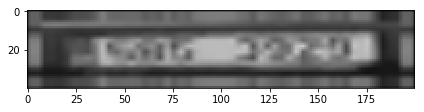

  　truth     =    ['5', 'B', '5', '#', '3', '9', '2', '9']
prediction　　  = ['5', 'B', '5', '#', '3', '9', '2', '3']
confidence　=　　 [0.97, 1.0, 1.0, 1.0, 1.0, 0.97, 1.0, 1.0]


top 2 prediction= ['8', '.', '7', '.', 'Q', '3', 'S', '2']
top 2 confidence= [0.01, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0]


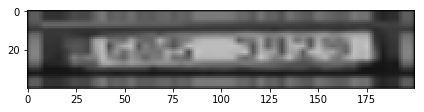

  　truth     =    ['5', 'B', '5', '#', '3', '9', '2', '9']
prediction　　  = ['5', 'B', '5', '#', '3', '1', '2', '8']
confidence　=　　 [0.99, 1.0, 1.0, 1.0, 1.0, 0.98, 1.0, 1.0]


top 2 prediction= ['4', '.', '7', '.', '5', '9', '7', '9']
top 2 confidence= [0.01, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0]


In [58]:
show_incorrect_prediction(incorrect_img,incorrect_groundtruth,incorrect_prediction_LP,incorrect_confidence,incorrect_topN_confidence,incorrect_topN_prediction,2)

 The License are totally correct recognized!  



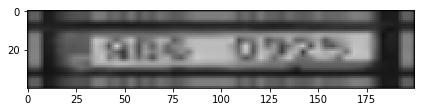


prediction　　=　　 ['9', 'B', '6', '#', '0', '9', '2', '5']
confidence　=　　 [0.98, 1.0, 1.0, 1.0, 0.54, 0.64, 1.0, 0.92]


top 2 prediction= ['1', '9', '4', '.', '5', '5', 'M', '8']
top 2 confidence= [0.02, 0.0, 0.0, 0.0, 0.44, 0.25, 0.0, 0.08]


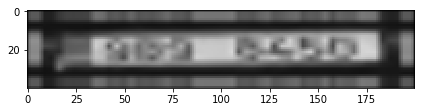


prediction　　=　　 ['9', 'B', '9', '#', '8', '4', '5', '0']
confidence　=　　 [0.82, 1.0, 0.92, 1.0, 0.96, 1.0, 1.0, 1.0]


top 2 prediction= ['1', '9', '7', 'M', '9', '5', '0', '6']
top 2 confidence= [0.16, 0.0, 0.07, 0.0, 0.04, 0.0, 0.0, 0.0]


In [50]:
show_incorrect_prediction(correct_img,correct_groundtruth,correct_prediction_LP,correct_confidence,correct_topN_confidence,correct_topN_prediction,number_of_images_to_show=2,typeofLP=False)


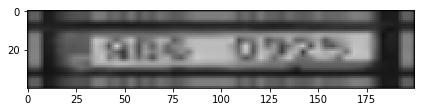

In [106]:
skimage.io.imshow(correct_img[0]*255)

In [265]:
print("\033[0;31;47m Bright Green  \n")

 Bright Green  



In [62]:
# list of numbers 
list1 = [10, 20, 4, 45, 99] 
  
# sorting the list 
list1.sort() 
  
# printing the second last element 
print("Second largest element is:", list1[-2]) 

Second largest element is: 45


In [60]:
print(i)

None


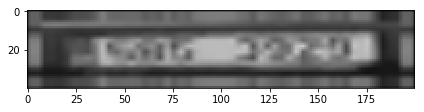

In [43]:
skimage.io.imshow(testX[0]*255)

In [50]:
testLabels

['5B5#3929']

In [48]:
for i in range(0,8):
    print(testY[i])

[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
def predict_image()

In [47]:
for i in range(0,8):
    print(int_to_char[argmax(p[i])])

5
B
5
#
3
9
2
3


license acc 0.0
character 0.875


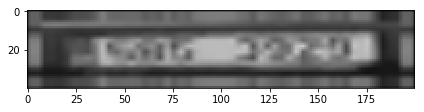

In [39]:
###character length 6
prediction_LP=[]
license=0
total_license=0
character =0 
total_character=0

for n in range(0,len(testX)):
    p=k_model.predict_on_batch(testX[n:n+1])
    truth = testY[n]
    
    for x in range(0,8):
        total_character+=1
        if int_to_char[argmax(truth[x])]==int_to_char[argmax(p[x])]:
            character+=1
    total_license+=1
    if (int_to_char[argmax(truth[0])]==int_to_char[argmax(p[0])] and
        int_to_char[argmax(truth[1])]==int_to_char[argmax(p[1])] and
        int_to_char[argmax(truth[2])]==int_to_char[argmax(p[2])] and 
        int_to_char[argmax(truth[3])]==int_to_char[argmax(p[3])] and
        int_to_char[argmax(truth[4])]==int_to_char[argmax(p[4])] and
        int_to_char[argmax(truth[5])]==int_to_char[argmax(p[5])] and
        int_to_char[argmax(truth[6])]==int_to_char[argmax(p[6])] and
        int_to_char[argmax(truth[7])]==int_to_char[argmax(p[7])]):
        license+=1
LP_acc1=license/total_license  
character_acc1=character/total_character
print("license acc",LP_acc1) 
print("character",character_acc1)
skimage.io.imshow(testImages[0])

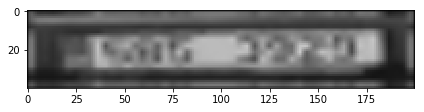

In [129]:
img=skimage.data.imread(row[1])
img = skimage.transform.resize(img,(10,50,3))
img = rgb2gray(img)
img = skimage.color.gray2rgb(img)


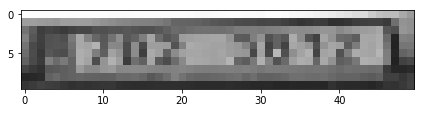

In [130]:
skimage.io.imshow(img)

In [131]:
#list_testLabels[0]

In [43]:
p=list(testY)
set(testY)

TypeError: unhashable type: 'numpy.ndarray'

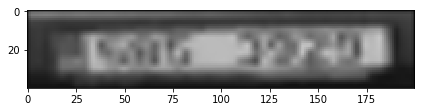

In [40]:
skimage.io.imshow(testX[0]*255)

In [68]:
img.mean()

0.46047982819124933

In [90]:
img=rgb2gray(img)
length=20
width =100
pad_shape = ((int(length), int(length)), (int(width), int(width)))
Image= pad(img, pad_width=pad_shape, mode='constant')

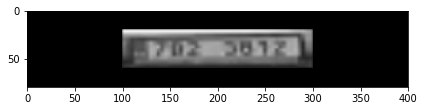

In [91]:
skimage.io.imshow(Image)

In [62]:
img.shape

(40, 200, 3)